In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_df = pd.read_csv('image_train_dataset.tsv', delimiter='\t')
total_samples = train_df.shape[0]
total_samples

35000

In [3]:
def preprocess_captions(caption_list):
    pc = []
    for caption in caption_list:
        caption = caption.strip().lower()
        caption = caption.replace('.', '').replace(',', '').replace("'", "").replace('"', '')
        caption = caption.replace('&','and').replace('(','').replace(')', '').replace('-', ' ')
        caption = ' '.join(caption.split()) 
        caption = '<START> '+caption+' <END>'
        pc.append(caption)
    return pc

In [4]:
train_captions = train_df.caption.tolist()
processed_train_captions = preprocess_captions(train_captions)

tc_tokens = [caption.split() for caption in processed_train_captions]
tc_tokens_length = [len(tokenized_caption) for tokenized_caption in tc_tokens]

In [5]:
from collections import Counter

tc_words = [word.strip() for word_list in tc_tokens for word in word_list]
unique_words = list(set(tc_words))
token_counter = Counter(unique_words)

word_to_index = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
word_to_index['<PAD>'] = 0
index_to_word = {index: word for word, index in word_to_index.items()}
vocab_size = len(word_to_index)
max_caption_size = np.max(tc_tokens_length)

In [6]:
from sklearn.externals import joblib

vocab_metadata = dict()
vocab_metadata['word2index'] = word_to_index
vocab_metadata['index2word'] = index_to_word
vocab_metadata['max_caption_size'] = max_caption_size
vocab_metadata['vocab_size'] = vocab_size

joblib.dump(vocab_metadata, 'vocabulary_metadata.pkl')

['vocabulary_metadata.pkl']

In [7]:
{k: v if type(v) is not dict 
         else list(v.items())[:5] 
             for k, v in vocab_metadata.items()}

{'index2word': [(0, '<PAD>'),
  (1, 'nearby'),
  (2, 'flooded'),
  (3, 'fundraising'),
  (4, 'snowboarder')],
 'max_caption_size': 39,
 'vocab_size': 7927,
 'word2index': [('reflections', 4122),
  ('flakes', 1829),
  ('flexing', 7684),
  ('scaling', 1057),
  ('pretend', 6788)]}

In [5]:
processed_train_captions[0]

'<START> a black dog is running after a white dog in the snow <END>'

In [6]:
from sklearn.externals import joblib

tl_img_feature_map = joblib.load('transfer_learn_img_features.pkl')
vocab_metadata = joblib.load('vocabulary_metadata.pkl')


train_img_names = train_df.image.tolist()
train_img_features = [tl_img_feature_map[img_name] for img_name in train_img_names]
train_img_features = np.array(train_img_features)

word_to_index = vocab_metadata['word2index']
index_to_word = vocab_metadata['index2word'] 
max_caption_size = vocab_metadata['max_caption_size']
vocab_size = vocab_metadata['vocab_size']

In [8]:
train_img_features.shape

(35000, 4096)

In [63]:
from keras.preprocessing import sequence

def dataset_generator(processed_captions, transfer_learnt_features, vocab_size, max_caption_size, batch_size=32):
    partial_caption_set = []
    next_word_seq_set = []
    img_feature_set = []
    batch_count = 0
    batch_num = 0
    
    while True:
        for index, caption in enumerate(processed_captions):
            img_features = transfer_learnt_features[index]
            for cap_idx in range(len(caption.split()) - 1):
                partial_caption = [word_to_index[word] for word in caption.split()[:cap_idx+1]]
                partial_caption_set.append(partial_caption)

                next_word_seq = np.zeros(vocab_size)
                next_word_seq[word_to_index[caption.split()[cap_idx+1]]] = 1
                next_word_seq_set.append(next_word_seq)
                img_feature_set.append(img_features)
                batch_count+=1

                if batch_count >= batch_size:
                    batch_num += 1
                    img_feature_set = np.array(img_feature_set)
                    partial_caption_set = sequence.pad_sequences(sequences=partial_caption_set, maxlen=max_caption_size, 
                                                                 padding='post')
                    next_word_seq_set = np.array(next_word_seq_set)
                    
                    yield [[img_feature_set, partial_caption_set], next_word_seq_set]
                    batch_count = 0
                    partial_caption_set = []
                    next_word_seq_set = []
                    img_feature_set = []

In [64]:
MAX_CAPTION_SIZE = max_caption_size
VOCABULARY_SIZE = vocab_size
BATCH_SIZE = 10

print('Vocab size:', VOCABULARY_SIZE)
print('Max caption size:', MAX_CAPTION_SIZE)
print('Test Batch size:', BATCH_SIZE)

d = dataset_generator(processed_captions=processed_train_captions, 
                  transfer_learnt_features=train_img_features, 
                  vocab_size=VOCABULARY_SIZE, max_caption_size=MAX_CAPTION_SIZE,
                  batch_size=BATCH_SIZE)
d = list(d)
img_features, partial_captions = d[0][0]
next_word = d[0][1]

Vocab size: 7927
Max caption size: 39
Test Batch size: 10


In [42]:
img_features.shape, partial_captions.shape, next_word.shape

((10, 4096), (10, 39), (10, 7927))

In [58]:
np.round(img_features, 3)

array([[0.   , 0.   , 1.704, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.704, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.704, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 1.704, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.704, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.704, ..., 0.   , 0.   , 0.   ]], dtype=float32)

In [66]:
print(np.array([partial_caption[:11] for partial_caption in partial_captions]))

[[6917    0    0    0    0    0    0    0    0    0    0]
 [6917 2578    0    0    0    0    0    0    0    0    0]
 [6917 2578 7371    0    0    0    0    0    0    0    0]
 [6917 2578 7371 3519    0    0    0    0    0    0    0]
 [6917 2578 7371 3519 3113    0    0    0    0    0    0]
 [6917 2578 7371 3519 3113 6720    0    0    0    0    0]
 [6917 2578 7371 3519 3113 6720    7    0    0    0    0]
 [6917 2578 7371 3519 3113 6720    7 2578    0    0    0]
 [6917 2578 7371 3519 3113 6720    7 2578 1076    0    0]
 [6917 2578 7371 3519 3113 6720    7 2578 1076 3519    0]]


In [67]:
print(np.array([[index_to_word[word] for word in cap][:11] for cap in partial_captions]))

[['<START>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
  '<PAD>' '<PAD>' '<PAD>']
 ['<START>' 'a' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
  '<PAD>' '<PAD>']
 ['<START>' 'a' 'black' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
  '<PAD>' '<PAD>']
 ['<START>' 'a' 'black' 'dog' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
  '<PAD>' '<PAD>']
 ['<START>' 'a' 'black' 'dog' 'is' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
  '<PAD>' '<PAD>']
 ['<START>' 'a' 'black' 'dog' 'is' 'running' '<PAD>' '<PAD>' '<PAD>'
  '<PAD>' '<PAD>']
 ['<START>' 'a' 'black' 'dog' 'is' 'running' 'after' '<PAD>' '<PAD>'
  '<PAD>' '<PAD>']
 ['<START>' 'a' 'black' 'dog' 'is' 'running' 'after' 'a' '<PAD>' '<PAD>'
  '<PAD>']
 ['<START>' 'a' 'black' 'dog' 'is' 'running' 'after' 'a' 'white' '<PAD>'
  '<PAD>']
 ['<START>' 'a' 'black' 'dog' 'is' 'running' 'after' 'a' 'white' 'dog'
  '<PAD>']]


In [52]:
next_word

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
print('Next word positions:', np.nonzero(next_word)[1])
print('Next words:', [index_to_word[word] for word in np.nonzero(next_word)[1]])

Next word positions: [2578 7371 3519 3113 6720    7 2578 1076 3519 5070]
Next words: ['a', 'black', 'dog', 'is', 'running', 'after', 'a', 'white', 'dog', 'in']


In [68]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, concatenate

DENSE_DIM = 256
EMBEDDING_DIM = 256
MAX_CAPTION_SIZE = max_caption_size
VOCABULARY_SIZE = vocab_size

image_model = Sequential()
image_model.add(Dense(DENSE_DIM, input_dim=4096, activation='relu'))
image_model.add(RepeatVector(MAX_CAPTION_SIZE))

language_model = Sequential()
language_model.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=MAX_CAPTION_SIZE))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(DENSE_DIM)))

merged_output = concatenate([image_model.output, language_model.output])
merged_output = LSTM(1024, return_sequences=False)(merged_output)
merged_output = (Dense(VOCABULARY_SIZE))(merged_output)
merged_output = Activation('softmax')(merged_output)

model = Model([image_model.input, language_model.input], merged_output)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [69]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1_input (InputLayer)   (None, 39)            0                                            
____________________________________________________________________________________________________
dense_1_input (InputLayer)       (None, 4096)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 39, 256)       2029312     embedding_1_input[0][0]          
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 256)           1048832     dense_1_input[0][0]              
___________________________________________________________________________________________

In [12]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.15,
                              patience=2, min_lr=0.000005)

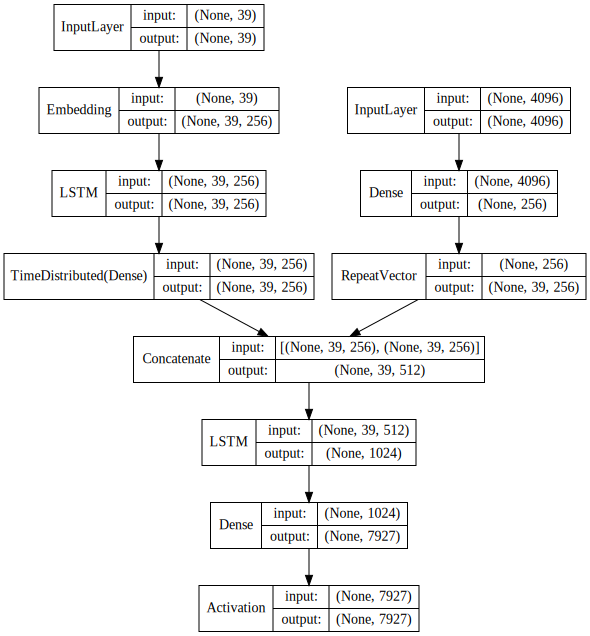

In [70]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
    rankdir='TB').create(prog='dot', format='svg'))

In [15]:
BATCH_SIZE = 256
EPOCHS = 30
cap_lens = [(cl-1) for cl in tc_tokens_length]
total_size = sum(cap_lens)

history = model.fit_generator(dataset_generator(processed_captions=processed_train_captions, 
                                                transfer_learnt_features=train_img_features, 
                                                vocab_size=VOCABULARY_SIZE, max_caption_size=MAX_CAPTION_SIZE,
                                                batch_size=BATCH_SIZE), 
                              steps_per_epoch=int(total_size/BATCH_SIZE), 
                              callbacks=[reduce_lr],
                              epochs=EPOCHS, verbose=1)

Epoch 1/30
1617/1617 [==============================] - 724s 448ms/step - loss: 4.1236 - acc: 0.2823
Epoch 2/30
1617/1617 [==============================] - 725s 448ms/step - loss: 3.9182 - acc: 0.3150
Epoch 3/30
1617/1617 [==============================] - 724s 448ms/step - loss: 3.8286 - acc: 0.3281
Epoch 4/30
1617/1617 [==============================] - 724s 448ms/step - loss: 3.8102 - acc: 0.3369
Epoch 5/30
1617/1617 [==============================] - 724s 448ms/step - loss: 3.7773 - acc: 0.3446
Epoch 6/30
1617/1617 [==============================] - 724s 448ms/step - loss: 3.7513 - acc: 0.3500
Epoch 7/30
1617/1617 [==============================] - 724s 448ms/step - loss: 3.7250 - acc: 0.3533
Epoch 8/30
1617/1617 [==============================] - 724s 448ms/step - loss: 3.7613 - acc: 0.3568
Epoch 9/30
1617/1617 [==============================] - 724s 448ms/step - loss: 3.7421 - acc: 0.3593
Epoch 10/30
1617/1617 [==============================] - 724s 448ms/step - loss: 3.6979 - a

In [16]:
model.save('ic_model_rmsprop_b256ep30.h5') 

In [22]:
EPOCHS = 50

history_rest = model.fit_generator(dataset_generator(processed_captions=processed_train_captions, 
                                                transfer_learnt_features=train_img_features, 
                                                vocab_size=VOCABULARY_SIZE, max_caption_size=MAX_CAPTION_SIZE,
                                                batch_size=BATCH_SIZE), 
                              steps_per_epoch=int(total_size/BATCH_SIZE), 
                              callbacks=[reduce_lr],
                              epochs=EPOCHS, verbose=1, initial_epoch=30)

Epoch 31/50
1617/1617 [==============================] - 724s 447ms/step - loss: 3.3988 - acc: 0.4144
Epoch 32/50
1617/1617 [==============================] - 724s 448ms/step - loss: 3.3633 - acc: 0.4184
Epoch 33/50
1617/1617 [==============================] - 724s 448ms/step - loss: 3.3374 - acc: 0.4221
Epoch 34/50
1617/1617 [==============================] - 724s 448ms/step - loss: 3.3186 - acc: 0.4249
Epoch 35/50
1617/1617 [==============================] - 724s 448ms/step - loss: 3.2979 - acc: 0.4275
Epoch 36/50
1617/1617 [==============================] - 724s 448ms/step - loss: 3.2795 - acc: 0.4298
Epoch 37/50
1617/1617 [==============================] - 724s 448ms/step - loss: 3.2644 - acc: 0.4321
Epoch 38/50
1617/1617 [==============================] - 724s 448ms/step - loss: 3.2503 - acc: 0.4342
Epoch 39/50
1617/1617 [==============================] - 724s 448ms/step - loss: 3.2368 - acc: 0.4358
Epoch 40/50
1617/1617 [==============================] - 724s 448ms/step - loss: 3

In [23]:
model.save('ic_model_rmsprop_b256ep50.h5') 

In [24]:
epochs = list(range(1,51))
losses = history.history['loss'] + history_rest.history['loss'] 
accs = history.history['acc'] + history_rest.history['acc'] 
lrs = history.history['lr'] + history_rest.history['lr'] 

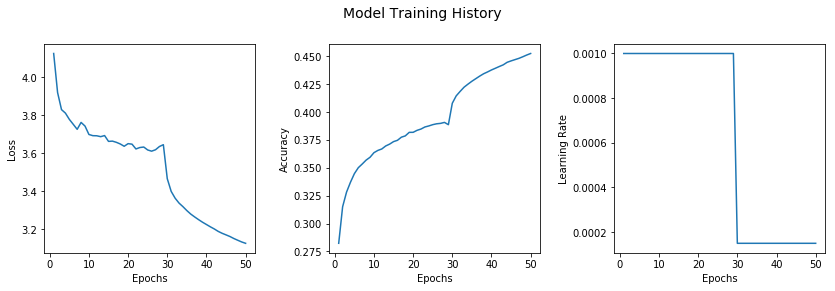

In [25]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
title = f.suptitle("Model Training History", fontsize=14)
f.subplots_adjust(top=0.85, wspace=0.35)

ax1.plot(epochs, losses, label='Loss')
ax2.plot(epochs, accs,  label='Accuracy')
ax3.plot(epochs, lrs, label='Learning Rate')

ax1.set_xlabel('Epochs')
ax2.set_xlabel('Epochs')
ax3.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
ax3.set_ylabel('Learning Rate')